In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import threadpoolctl
threadpoolctl.threadpool_limits(1, "blas")

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from rectools.dataset import Dataset
from rectools.metrics import (
    NDCG,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
    CatalogCoverage
)
from rectools.models import PopularModel, EASEModel, SASRecModel, ImplicitALSWrapperModel
from rectools.model_selection import TimeRangeSplitter, cross_validate

from implicit.als import AlternatingLeastSquares
from catboost import CatBoostRanker, Pool


In [2]:
interactions = pd.read_csv("data/interactions.csv")
items = pd.read_csv("data/items.csv")
users = pd.read_csv("data/users.csv")

# EDA

Посмотрим на данные

In [3]:
interactions

,user_id,item_id,datetime,action
0,0,11.0,2025-05-28 07:36:48.225275608,click
1,0,73.0,2025-07-21 17:26:51.803754354,click
2,0,51.0,2025-05-05 20:20:44.838313014,click
3,0,74.0,2025-04-29 05:29:06.051551314,click
4,0,38.0,2025-04-07 14:57:00.062975580,click
...,...,...,...,...
3941443,9999,6.0,2025-07-12 18:48:25.630890802,show
3941444,9999,29.0,2025-07-12 18:48:25.630890802,show
3941445,9999,58.0,2025-07-12 18:48:25.630890802,show
3941446,9999,NaN,2025-07-05 06:57:18.551431996,show


In [4]:
interactions['action'].value_counts()

action
show     3861511
click      79937
Name: count, dtype: int64

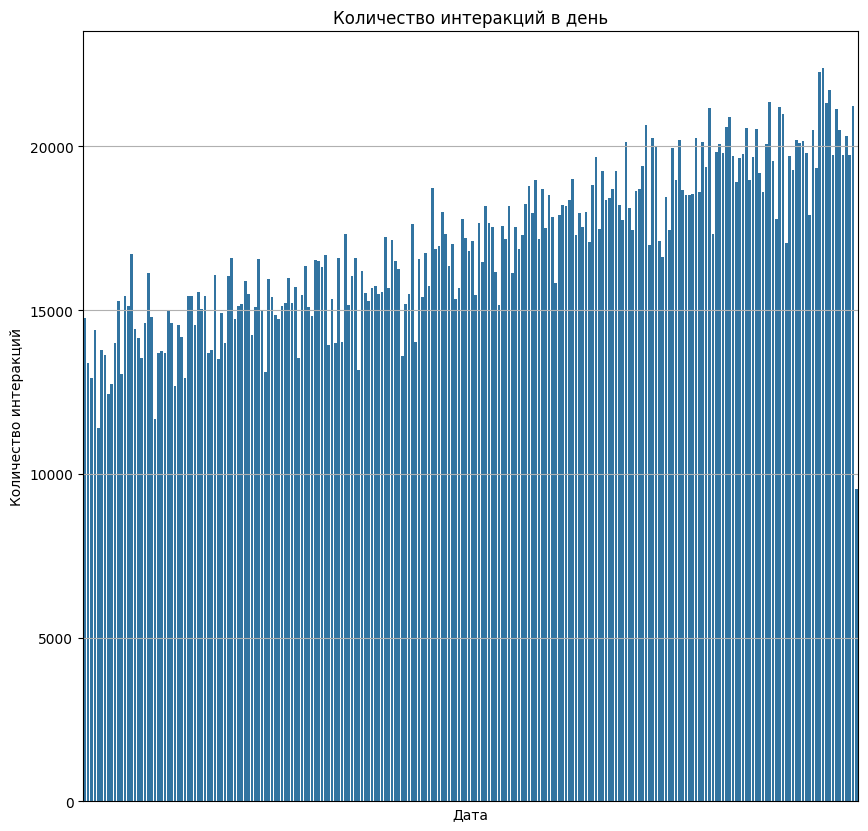

In [5]:
interactions_plot_df = interactions.copy()
interactions_plot_df["date"] = pd.to_datetime(interactions_plot_df["datetime"]).dt.date

interactions_plot_df = interactions_plot_df.groupby(["date"])[interactions_plot_df.columns[0]].count().reset_index()


plt.figure(figsize=(10,10))
sns.barplot(x='date', y='user_id', data=interactions_plot_df)
plt.xlabel('Дата')
plt.xticks([])
plt.ylabel('Количество интеракций')
plt.title('Количество интеракций в день')
plt.grid(True)
plt.show()

In [6]:
items

,item_id,genre,mean_users_score
0,0,Комедия,1.872701
1,1,Драма,4.753572
2,2,Мелодрама,3.659970
3,3,Драма,2.993292
4,4,Фантастика,0.780093
...,...,...,...
95,95,Мелодрама,2.468978
96,96,Драма,2.613664
97,97,Мелодрама,2.137705
98,98,Мелодрама,0.127096


In [7]:
items.value_counts("genre")

genre
Мелодрама     27
Драма         23
Триллер       18
Комедия       16
Фантастика    16
Name: count, dtype: int64

In [8]:
users

,user_id,sex_type
0,0,M
1,1,F
2,2,M
3,3,M
4,4,M
...,...,...
9995,9995,M
9996,9996,F
9997,9997,M
9998,9998,M


In [9]:
users.value_counts("sex_type")

sex_type
F    5005
M    4995
Name: count, dtype: int64

# Готовим модели

Разделим выборку на 2 части  по времени:


На 1 - ой части мы будем обучать модели, доступные из коробки в rectools, а также считать фичи для катбуста

На 2 - ой части мы будем стакать результаты моделей в катбуст

In [10]:
interactions["weight"] = 1.0

def split_time(datetimes, test_size=0.5):
    datetimes_sorted = datetimes.sort_values().reset_index(drop=True)
    split_date = datetimes_sorted[int(datetimes_sorted.shape[0] * test_size)]
    return datetimes_sorted[datetimes_sorted < split_date].reset_index(drop=True), datetimes_sorted[datetimes_sorted >= split_date].reset_index(drop=True)
    
first_part, second_part = split_time(interactions["datetime"])

interactions_first_period = interactions[interactions["datetime"].isin(first_part)]
interactions_second_period = interactions[interactions["datetime"].isin(second_part)]

# Для некоторых моделе нужны только позитивные взаимодействия
positive_interactions_first_period = interactions_first_period[interactions_first_period["action"] == "click"]


Инициируем рекоменедателные модели

In [11]:
dataset = Dataset.construct(
    interactions_df=positive_interactions_first_period,
)

sasrec = SASRecModel(
    session_max_len=20,
    loss="softmax",
    n_factors=64,
    n_blocks=1,
    n_heads=4,
    dropout_rate=0.2,
    lr=0.001,
    batch_size=128,
    epochs=1,
    verbose=1,
    deterministic=True,
)
ease = EASEModel()
als = ImplicitALSWrapperModel(AlternatingLeastSquares(factors=32, num_threads=7))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Посомтрим качество базовых моделей

In [12]:
splitter = TimeRangeSplitter(
    test_size="14D",
    n_splits=5,
    filter_already_seen=True,
)

models = {
    "popular": PopularModel(),
    "ease": ease,
    "sasrec": sasrec,
    "als": als
}

metrics = {
    "HitRate@6": HitRate(k=6),
    "NDCG@6": NDCG(k=6),
    "CatalogCoverage@6": CatalogCoverage(k=6, normalize=True), # Процент объектов из каталога, которые попали в топ 6 рекомендаций хоть кому-то
    "AvgRecPopularity@6": AvgRecPopularity(k=6),  # Средняя популярность по топ 6 объектам
    "Intersection@6": Intersection(k=6),  # Процент объектов в рекомендациях, которая пересекается с топ 6
    "Serendipity@6": Serendipity(k=6),
}

K_RECS = 10

cv_results = cross_validate(
    dataset=dataset,
    splitter=splitter,
    models=models,
    metrics=metrics,
    k=K_RECS,
    filter_viewed=True,
    ref_models=["popular"],  # Модель с которой считаем пересечение
    validate_ref_models=True
)

pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean"])
)
pivot_results.columns = pivot_results.columns.droplevel(1)
pivot_results


  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 42/42 [00:01<00:00, 27.17it/s, v_num=99, train_loss=4.920]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 42/42 [00:01<00:00, 27.11it/s, v_num=99, train_loss=4.920]



  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 30.84it/s, v_num=100, train_loss=4.850]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 51/51 [00:01<00:00, 30.79it/s, v_num=100, train_loss=4.850]



  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 59/59 [00:01<00:00, 30.87it/s, v_num=101, train_loss=4.850]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 59/59 [00:01<00:00, 30.84it/s, v_num=101, train_loss=4.850]



  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 64/64 [00:02<00:00, 25.04it/s, v_num=102, train_loss=4.840]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 64/64 [00:02<00:00, 25.00it/s, v_num=102, train_loss=4.840]



  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 68/68 [00:03<00:00, 19.10it/s, v_num=103, train_loss=4.820]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 68/68 [00:03<00:00, 19.09it/s, v_num=103, train_loss=4.820]


,HitRate@6,NDCG@6,CatalogCoverage@6,AvgRecPopularity@6,Serendipity@6,Intersection@6_popular
model,,,,,,
popular,0.092792,0.015584,0.090,338.883261,0.000016,1.000000
ease,0.098184,0.016712,1.000,297.286664,0.002996,0.116155
sasrec,0.086471,0.014707,0.508,316.207987,0.001738,0.257199
als,0.091879,0.015655,0.708,303.550703,0.002869,0.058312


Обучаем наши модели на 1-ой части данных

In [13]:
%%time
sasrec.fit(dataset)
ease.fit(dataset)
als.fit(dataset)


  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 33.1 K | train
-----------------------------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 72/72 [00:02<00:00, 29.86it/s, v_num=104, train_loss=4.820]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 72/72 [00:02<00:00, 29.83it/s, v_num=104, train_loss=4.820]
CPU times: user 3.58 s, sys: 398 ms, total: 3.98 s
Wall time: 3.56 s


In [14]:
# Скорим базовые модели
recom_sasrec = sasrec.recommend(users=dataset.user_id_map.external_ids, dataset=dataset, filter_viewed=True, k=100).drop(columns=['rank']).rename(columns={"score": "sasrec_score"})
recom_ease = ease.recommend(users=dataset.user_id_map.external_ids, dataset=dataset, filter_viewed=True, k=100).drop(columns=['rank']).rename(columns={"score": "ease_score"})
recom_als = als.recommend(users=dataset.user_id_map.external_ids, dataset=dataset, filter_viewed=True, k=100).drop(columns=['rank']).rename(columns={"score": "als_score"})

# Обучаемся - на логах
target_df = interactions_second_period[["user_id", "item_id"]].drop_duplicates()
target_df["target"] = interactions_second_period["action"].map({"click": 1, "show": 0})

# Собираем общий датасет
all_features = target_df
all_features = all_features.merge(users, on=["user_id"], how="left")
all_features = all_features.merge(items, on=["item_id"], how="left")
all_features = all_features.merge(recom_sasrec, on=["user_id", "item_id"], how="left")
all_features = all_features.merge(recom_ease, on=["user_id", "item_id"], how="left")
all_features = all_features.merge(recom_als, on=["user_id", "item_id"], how="left")

all_features = all_features.fillna(0)

all_features

,user_id,item_id,target,sex_type,genre,mean_users_score,sasrec_score,ease_score,als_score
0,0,11.0,1,M,Триллер,4.849549,0.122505,0.060622,0.238847
1,0,73.0,1,M,Триллер,4.077307,0.461171,0.064726,-0.117233
2,0,31.0,1,M,Триллер,0.852621,0.453634,0.066657,0.088812
3,0,40.0,1,M,Триллер,0.610191,0.385494,0.063625,0.142132
4,0,83.0,1,M,Триллер,0.317792,0.522651,0.063909,0.084163
...,...,...,...,...,...,...,...,...,...
743735,9999,32.0,0,M,Драма,0.325258,0.058784,0.021824,0.027490
743736,9999,6.0,0,M,Фантастика,0.290418,0.246226,0.014991,-0.039314
743737,9999,29.0,0,M,Комедия,0.232252,-0.081325,0.005127,-0.009045
743738,9999,58.0,0,M,Триллер,0.226136,0.509539,0.019095,-0.132416


In [15]:
# Разделяем пользователей на тренировочную и валидационную выборки - важно что бы пользователь полностью попал либо в трейн, kb,j d dfkblfwb.
train_users, val_users = train_test_split(all_features["user_id"].drop_duplicates(), test_size=0.25, random_state=42)

data_train = all_features[all_features["user_id"].isin(train_users)].sort_values("user_id")
data_val = all_features[all_features["user_id"].isin(val_users)].sort_values("user_id")

X_train = data_train.drop(columns="target")
X_val = data_val.drop(columns="target")
y_train = data_train["target"]
y_val = data_val["target"]

In [16]:
train_pool = Pool(data=X_train.drop(columns=["user_id", "item_id"]), label=y_train, group_id=X_train["user_id"], cat_features=['sex_type', 'genre'])
val_pool = Pool(data=X_val.drop(columns=["user_id", "item_id"]), label=y_val, group_id=X_val["user_id"], cat_features=['sex_type', 'genre'])


model = CatBoostRanker(
    iterations=100,             
    learning_rate=0.1,          
    depth=6,                    
    early_stopping_rounds=3
)

model.fit(train_pool, eval_set=val_pool) 


Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.4287238	best: 0.4287238 (0)	total: 372ms	remaining: 36.8s
1:	test: 0.4693830	best: 0.4693830 (1)	total: 608ms	remaining: 29.8s
2:	test: 0.5582276	best: 0.5582276 (2)	total: 884ms	remaining: 28.6s
3:	test: 0.5853166	best: 0.5853166 (3)	total: 1.15s	remaining: 27.6s
4:	test: 0.5959806	best: 0.5959806 (4)	total: 1.41s	remaining: 26.8s
5:	test: 0.6169102	best: 0.6169102 (5)	total: 1.7s	remaining: 26.6s
6:	test: 0.6356061	best: 0.6356061 (6)	total: 2.02s	remaining: 26.8s
7:	test: 0.6362885	best: 0.6362885 (7)	total: 2.28s	remaining: 26.3s
8:	test: 0.6526930	best: 0.6526930 (8)	total: 2.55s	remaining: 25.8s
9:	test: 0.6576445	best: 0.6576445 (9)	total: 2.81s	remaining: 25.3s
10:	test: 0.6652255	best: 0.6652255 (10)	total: 3.1s	remaining: 25.1s
11:	test: 0.6737283	best: 0.6737283 (11)	total: 3.43s	remaining: 25.2s
12:	test: 0.6797740	best: 0.6797740 (12)	total: 3.69s	remaining: 24.7s
13:	test: 0.6807699	best: 0.6807699 (13)	total: 3.